# **Auto Insurance Fraud Detection** 🚗

## 1. Project Overview
The aim of this project is to develop a **fraud detection model** using machine learning, specifically targeting auto insurance claims. A common challenge in fraud detection is the **imbalance within the dataset**, where the majority of cases are non-fraudulent. This project aims to address this issue as well. Given the higher importance of recall (minimizing false negatives) and the fact that the data is imbalanced, ROC-AUC scores and F-beta (beta=5) will be used as evaluation metrics. 

The data used in this project was sourced from Kaggle and can be found [here](https://www.kaggle.com/datasets/buntyshah/auto-insurance-claims-data/data). 

### Import necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.pipeline import Pipeline, FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, learning_curve
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import make_scorer, fbeta_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

## 2. Load and Investigate the Dataset

In [11]:
# Load data
df = pd.read_csv("insurance_claims.csv")
df.columns = df.columns.str.upper()

print("Shape of the dataset: ", df.shape)
df.head()

Shape of the dataset:  (1000, 40)


,MONTHS_AS_CUSTOMER,AGE,POLICY_NUMBER,POLICY_BIND_DATE,POLICY_STATE,POLICY_CSL,POLICY_DEDUCTABLE,POLICY_ANNUAL_PREMIUM,UMBRELLA_LIMIT,INSURED_ZIP,...,POLICE_REPORT_AVAILABLE,TOTAL_CLAIM_AMOUNT,INJURY_CLAIM,PROPERTY_CLAIM,VEHICLE_CLAIM,AUTO_MAKE,AUTO_MODEL,AUTO_YEAR,FRAUD_REPORTED,_C39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MONTHS_AS_CUSTOMER           1000 non-null   int64  
 1   AGE                          1000 non-null   int64  
 2   POLICY_NUMBER                1000 non-null   int64  
 3   POLICY_BIND_DATE             1000 non-null   object 
 4   POLICY_STATE                 1000 non-null   object 
 5   POLICY_CSL                   1000 non-null   object 
 6   POLICY_DEDUCTABLE            1000 non-null   int64  
 7   POLICY_ANNUAL_PREMIUM        1000 non-null   float64
 8   UMBRELLA_LIMIT               1000 non-null   int64  
 9   INSURED_ZIP                  1000 non-null   int64  
 10  INSURED_SEX                  1000 non-null   object 
 11  INSURED_EDUCATION_LEVEL      1000 non-null   object 
 12  INSURED_OCCUPATION           1000 non-null   object 
 13  INSURED_HOBBIES    

In [20]:
# Count occurences of fraud vs non-fraudulent claims
occ = df["FRAUD_REPORTED"].value_counts()
print(occ)

# Ratio of fraudulent claims
ratio = occ / len(df) * 100
print(ratio)

FRAUD_REPORTED
N    753
Y    247
Name: count, dtype: int64
FRAUD_REPORTED
N    75.3
Y    24.7
Name: count, dtype: float64


In [21]:
# Descriptive summary
df.describe()

,MONTHS_AS_CUSTOMER,AGE,POLICY_NUMBER,POLICY_DEDUCTABLE,POLICY_ANNUAL_PREMIUM,UMBRELLA_LIMIT,INSURED_ZIP,CAPITAL-GAINS,CAPITAL-LOSS,INCIDENT_HOUR_OF_THE_DAY,NUMBER_OF_VEHICLES_INVOLVED,BODILY_INJURIES,WITNESSES,TOTAL_CLAIM_AMOUNT,INJURY_CLAIM,PROPERTY_CLAIM,VEHICLE_CLAIM,AUTO_YEAR,_C39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


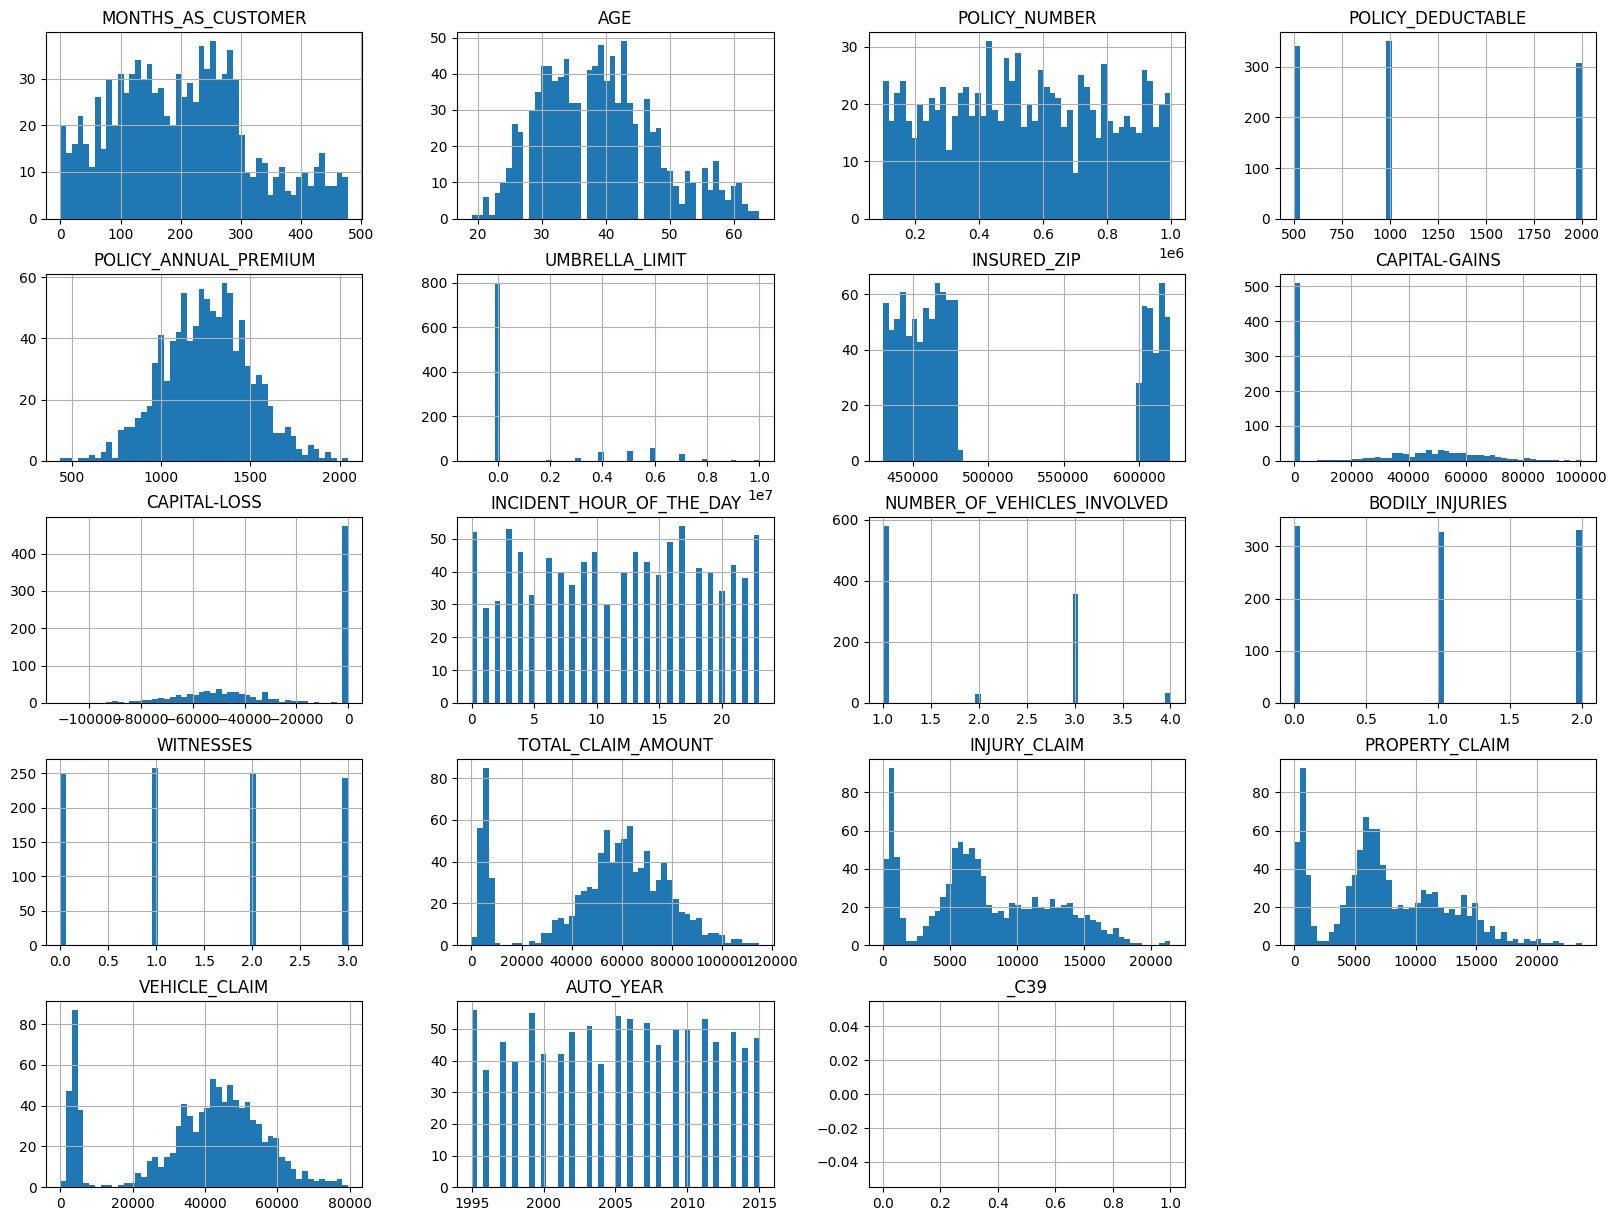

In [22]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

### 2.1 Divide into train and test set
To prevent data leakage, the data is split into training and test sets before any further exploration and manipulation of the data is conducted. A stratified sampling method is used during the data split, to ensure proportional class representation in both sets. 

In [23]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["FRAUD_REPORTED"])  

In [24]:
print(train.shape)
train["FRAUD_REPORTED"].value_counts(normalize=True) * 100    # Looks right!

(800, 40)


FRAUD_REPORTED
N    75.25
Y    24.75
Name: proportion, dtype: float64

In [25]:
train_raw = train.copy()    # Creating a copy of the training data that will be used during EDA and initial data cleaning procedures

## 3. Data Cleaning

- Handling inconsistencies and missing values

In [26]:
# From the summary we found that "insured_zip" was wrongly categorized as numerical
train_raw[["INSURED_ZIP", "POLICY_NUMBER"]] = train_raw[["INSURED_ZIP", "POLICY_NUMBER"]].astype(str)

# The "_C39" column is empty
train_raw.drop("_C39", axis=1, inplace=True)

In [27]:
# Check if there are any duplicate values
train_raw.duplicated().sum()

0

### Missing values

C:\Users\tovat\AppData\Local\Temp\ipykernel_13364\3187846783.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_proportion.index, y=na_proportion.values, palette='viridis')


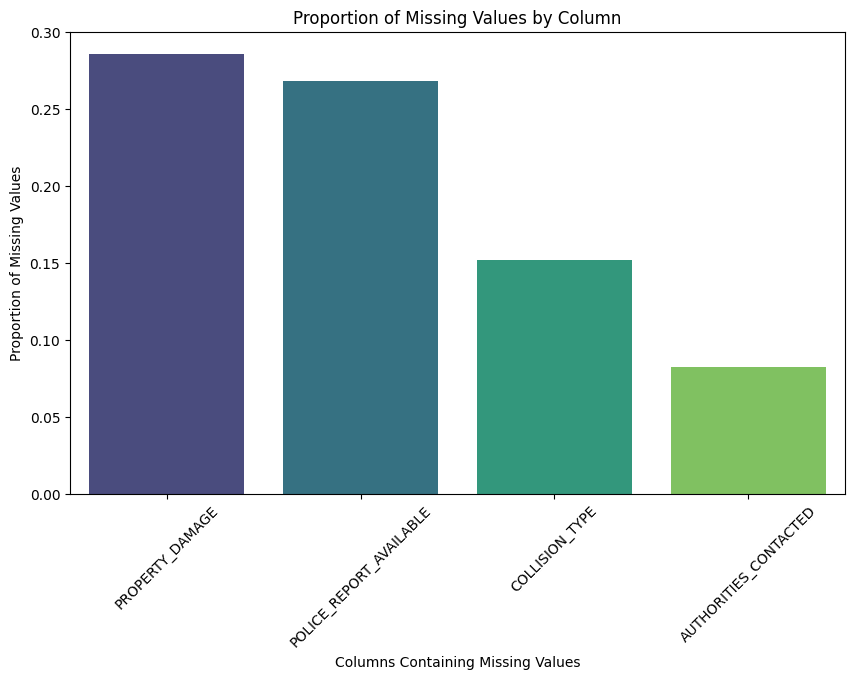

In [28]:
# Replace "?" with NaNs
train_raw = train_raw.replace("?", np.nan)

# Investigate which columns contain missing values and the proportion of NaNs in these columns
na_counts = train_raw.isna().sum()
na_cols = na_counts[na_counts > 0]
na_proportion = na_cols / len(df)  
na_proportion = na_proportion.sort_values(ascending=False)

# Visualize the proportion of missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=na_proportion.index, y=na_proportion.values, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Proportion of Missing Values')
plt.xlabel('Columns Containing Missing Values')
plt.title('Proportion of Missing Values by Column')
plt.show()

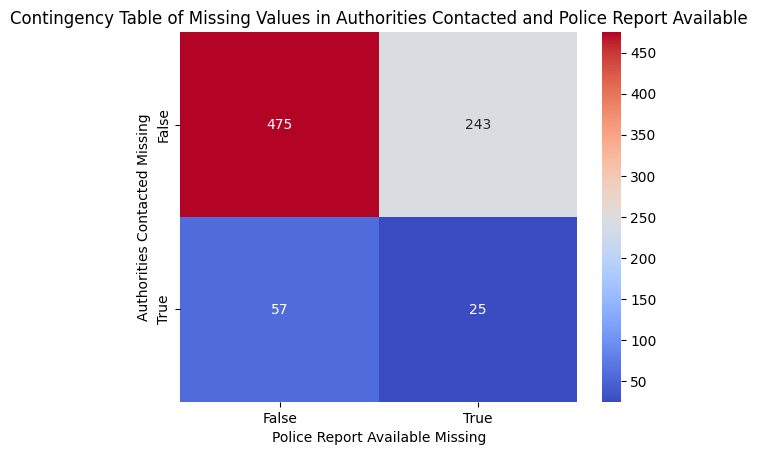

In [29]:
# Check relationship between authorities contacted and police report available, to see if there is a pattern that could explain the missing values
contingency_table = pd.crosstab(train_raw['AUTHORITIES_CONTACTED'].isna(), train_raw['POLICE_REPORT_AVAILABLE'].isna())

sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title('Contingency Table of Missing Values in Authorities Contacted and Police Report Available')
plt.xlabel('Police Report Available Missing')
plt.ylabel('Authorities Contacted Missing')
plt.savefig("Corr_missing_values.png")
plt.show()

#### Property damage and property claims
Analyzing the relationship between property damage responses to property claims, to see if there is a pattern that could help with handling the missing values in property damage.

Findings from the analysis in the cell below:
- There does not seem to be a clear relationship between property damage and property claim.
- Even in cases when no property damage was reported, there are still property claims filed. This could be interpreted as property not damaged but lost or stolen. 
- For reports with missing values in property damage, there are only 7 cases where the property claim is 0 USD -- further confirming the theory that property claim also involves lost or stolen goods. 

This suggests that the occurrence of property damage does not necessarily correlate directly with the filing of property claims. The analysis concludes that property damage would have been reported if eligible and will therefore be interpreted as "NO".

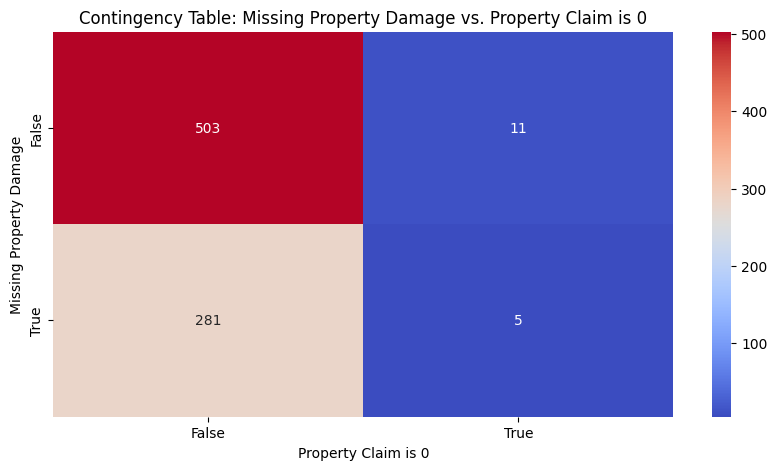

In [30]:
contingency_table = pd.crosstab(train_raw['PROPERTY_DAMAGE'].isna(), train_raw['PROPERTY_CLAIM'] == 0)

plt.figure(figsize=(10, 5))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm')
plt.title('Contingency Table: Missing Property Damage vs. Property Claim is 0')
plt.xlabel('Property Claim is 0')
plt.ylabel('Missing Property Damage')
plt.show()

In [31]:
# Imputing missing values

train_raw["COLLISION_TYPE"] = df["COLLISION_TYPE"].fillna(train_raw["COLLISION_TYPE"].mode()[0])
train_raw["PROPERTY_DAMAGE"] = train_raw["PROPERTY_DAMAGE"].fillna("NO")
train_raw["POLICE_REPORT_AVAILABLE"] = train_raw["POLICE_REPORT_AVAILABLE"].fillna("NO")
train_raw["AUTHORITIES_CONTACTED"] = train_raw["AUTHORITIES_CONTACTED"].fillna("None")
print(train_raw["AUTHORITIES_CONTACTED"].value_counts())

AUTHORITIES_CONTACTED
Police       235
Fire         173
Other        156
Ambulance    154
None          82
Name: count, dtype: int64


In [32]:
train_raw.isna().sum()   # There are no missing values left!

MONTHS_AS_CUSTOMER             0
AGE                            0
POLICY_NUMBER                  0
POLICY_BIND_DATE               0
POLICY_STATE                   0
POLICY_CSL                     0
POLICY_DEDUCTABLE              0
POLICY_ANNUAL_PREMIUM          0
UMBRELLA_LIMIT                 0
INSURED_ZIP                    0
INSURED_SEX                    0
INSURED_EDUCATION_LEVEL        0
INSURED_OCCUPATION             0
INSURED_HOBBIES                0
INSURED_RELATIONSHIP           0
CAPITAL-GAINS                  0
CAPITAL-LOSS                   0
INCIDENT_DATE                  0
INCIDENT_TYPE                  0
COLLISION_TYPE                 0
INCIDENT_SEVERITY              0
AUTHORITIES_CONTACTED          0
INCIDENT_STATE                 0
INCIDENT_CITY                  0
INCIDENT_LOCATION              0
INCIDENT_HOUR_OF_THE_DAY       0
NUMBER_OF_VEHICLES_INVOLVED    0
PROPERTY_DAMAGE                0
BODILY_INJURIES                0
WITNESSES                      0
POLICE_REP

## 4. EDA
- Visualize feature distributions and patterns
- Identify outliers
- Examine correlations and relationships between features

### 4.1 Numerical features

In [33]:
# Subset to only numerical features
num_train = train_raw.select_dtypes(include='number')
num_train.head()

,MONTHS_AS_CUSTOMER,AGE,POLICY_DEDUCTABLE,POLICY_ANNUAL_PREMIUM,UMBRELLA_LIMIT,CAPITAL-GAINS,CAPITAL-LOSS,INCIDENT_HOUR_OF_THE_DAY,NUMBER_OF_VEHICLES_INVOLVED,BODILY_INJURIES,WITNESSES,TOTAL_CLAIM_AMOUNT,INJURY_CLAIM,PROPERTY_CLAIM,VEHICLE_CLAIM,AUTO_YEAR
887,441,55,500,1270.29,4000000,24000,-50500,4,1,0,0,6400,640,640,5120,2002
317,275,45,2000,1447.77,0,39400,-63900,8,3,1,1,64320,5360,10720,48240,1998
796,421,56,500,1935.85,4000000,49500,-81100,7,1,2,3,92730,16860,8430,67440,2004
425,4,34,500,1282.93,0,0,0,0,4,0,0,66880,6080,12160,48640,1996
991,257,44,1000,1280.88,0,59400,-32200,21,1,0,1,46980,0,5220,41760,2002


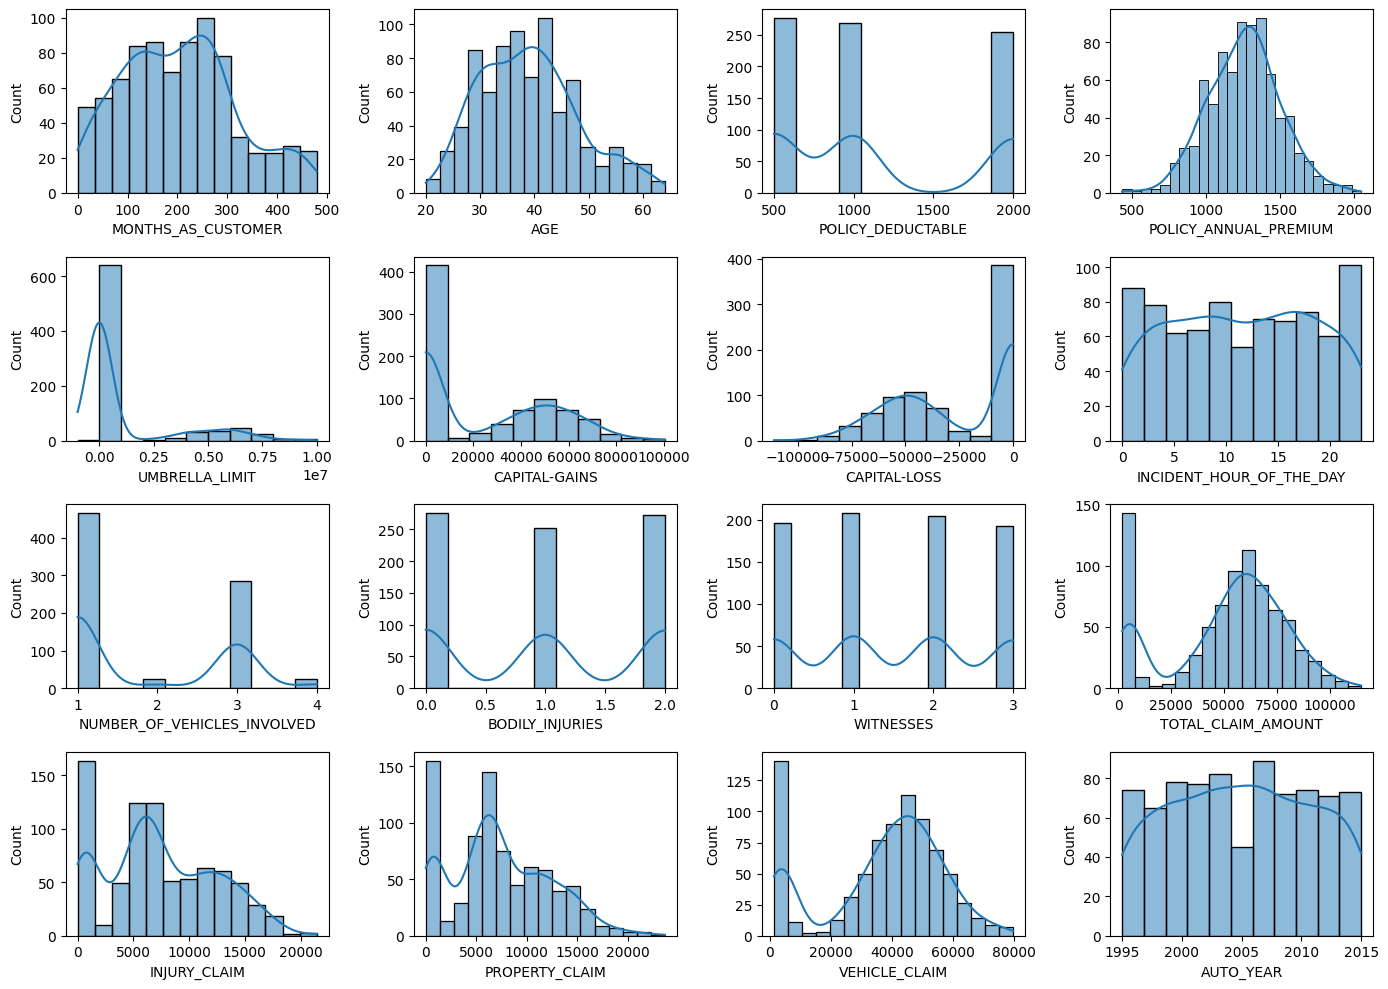

In [34]:
# Visualize distributions
fig, axes = plt.subplots(4, 4, figsize=(14,10))
axes = axes.flatten()

for i, col in enumerate(num_train):
    sns.histplot(num_train[col], kde=True, ax=axes[i])

plt.tight_layout()
plt.savefig('num_features_distribution.png')
plt.show()

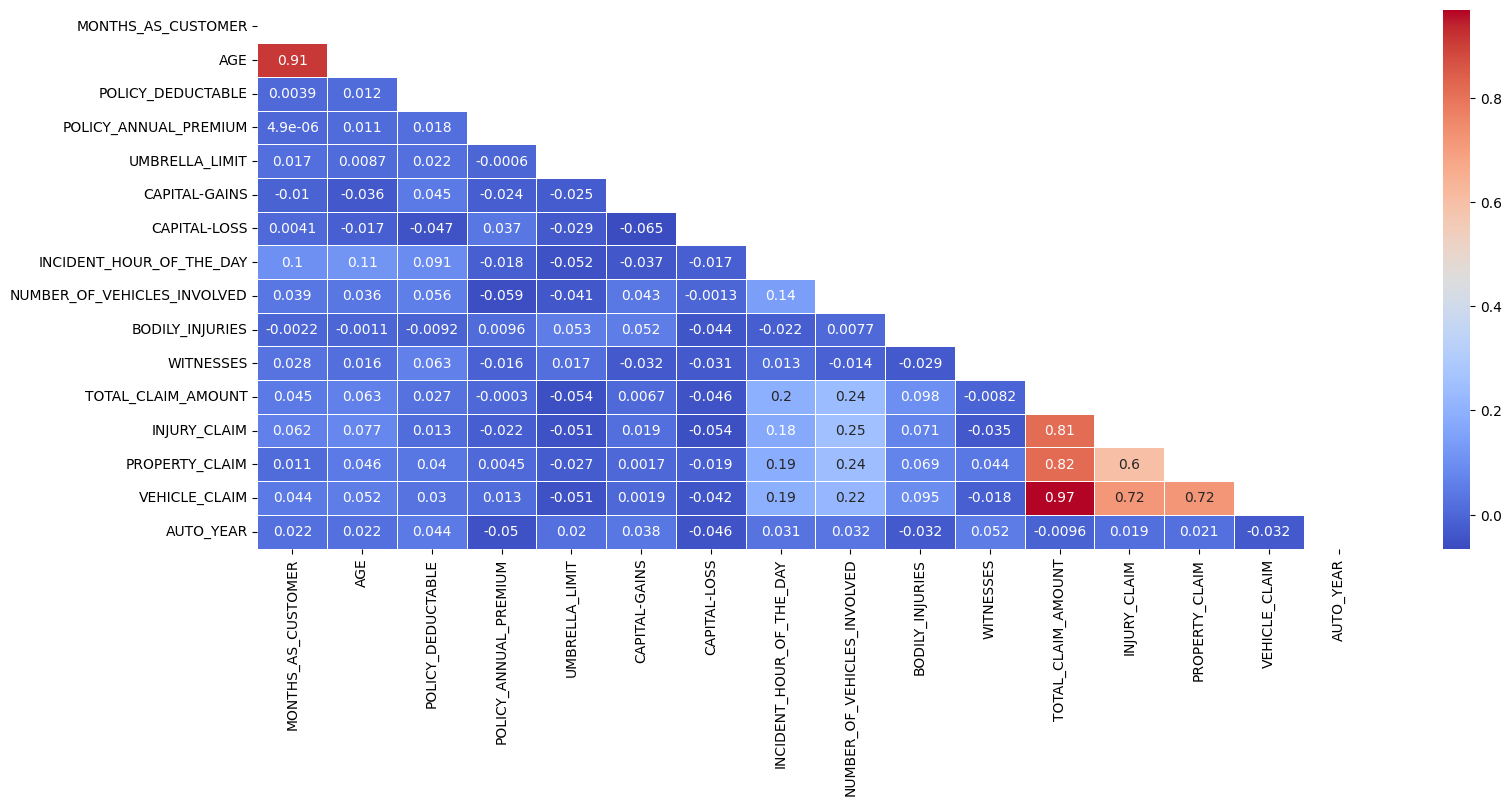

In [35]:
plt.set_style='notebook'
plt.figure(figsize=(18,7))

# Using Spearman's rank to capture non-linear relationships
corr_matrix_spearman = num_train.corr(method='spearman')

# Applying a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix_spearman, dtype=bool))

sns.heatmap(corr_matrix_spearman, mask=mask, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

### Outliers

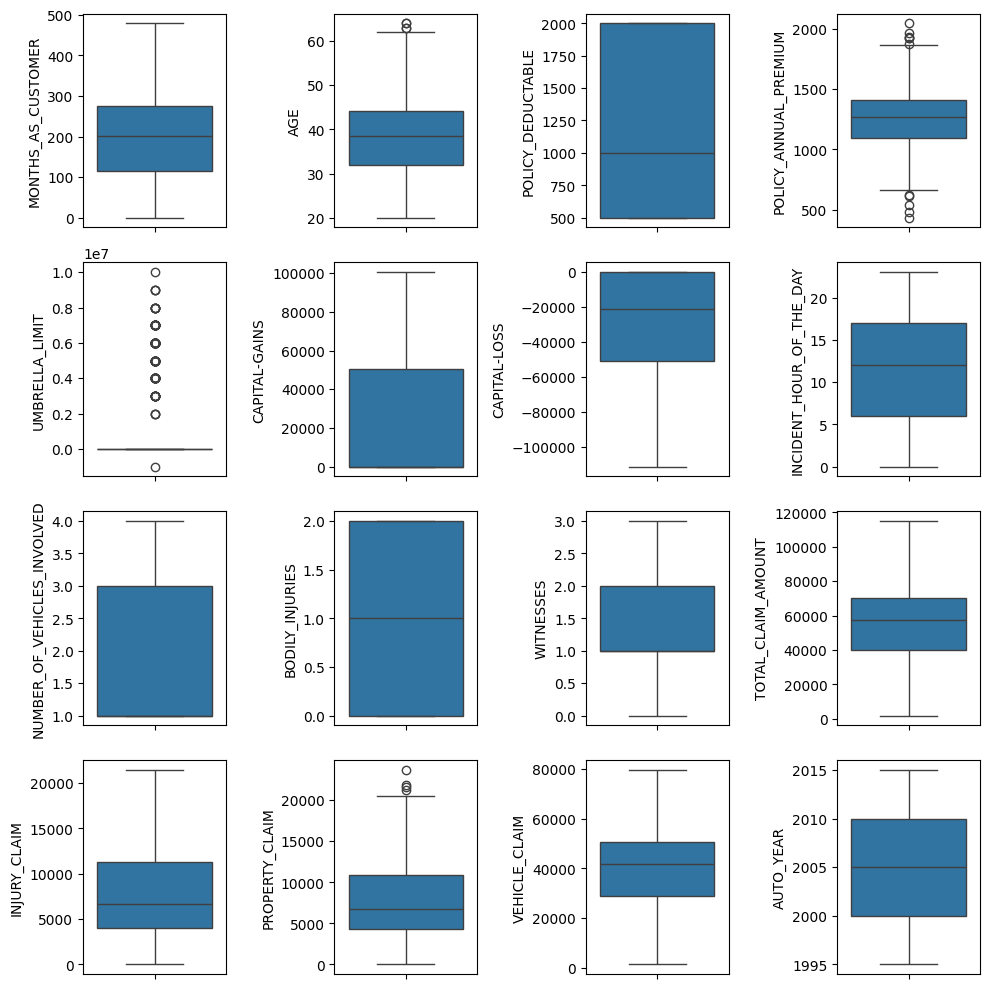

In [36]:
# Visualize distributions
fig, axes = plt.subplots(4,4, figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(num_train):
    if num_train[col].dtype != object:
        sns.boxplot(num_train[col], ax=axes[i])

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [57]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

detect_outliers(num_train)

,Outlier_percentage
UMBRELLA_LIMIT,20.125
POLICY_ANNUAL_PREMIUM,1.375
AGE,0.500
PROPERTY_CLAIM,0.500
MONTHS_AS_CUSTOMER,0.000
POLICY_DEDUCTABLE,0.000
CAPITAL-GAINS,0.000
CAPITAL-LOSS,0.000
INCIDENT_HOUR_OF_THE_DAY,0.000
NUMBER_OF_VEHICLES_INVOLVED,0.000


<Axes: xlabel='UMBRELLA_LIMIT', ylabel='Count'>

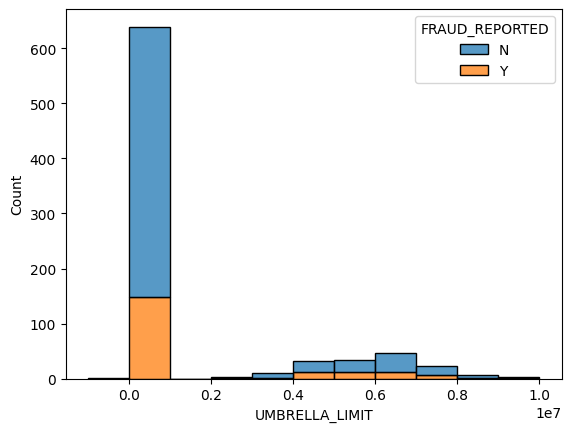

In [37]:
sns.histplot(train_raw, x="UMBRELLA_LIMIT", hue="FRAUD_REPORTED", multiple="stack")

### 4.2 Categorical features

In [38]:
cat_train = train_raw.select_dtypes(include=['object'])
cat_train.head()

,POLICY_NUMBER,POLICY_BIND_DATE,POLICY_STATE,POLICY_CSL,INSURED_ZIP,INSURED_SEX,INSURED_EDUCATION_LEVEL,INSURED_OCCUPATION,INSURED_HOBBIES,INSURED_RELATIONSHIP,...,INCIDENT_SEVERITY,AUTHORITIES_CONTACTED,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_LOCATION,PROPERTY_DAMAGE,POLICE_REPORT_AVAILABLE,AUTO_MAKE,AUTO_MODEL,FRAUD_REPORTED
887,669501,2009-07-29,IN,250/500,449421,MALE,College,armed-forces,exercise,husband,...,Minor Damage,None,VA,Arlington,9988 Rock Ridge,NO,NO,Honda,Civic,N
317,403737,1991-12-06,IN,500/1000,605756,FEMALE,Associate,adm-clerical,camping,wife,...,Total Loss,Ambulance,VA,Northbend,3835 5th Ave,YES,NO,Accura,MDX,N
796,728025,1990-02-15,IN,100/300,470826,MALE,Masters,machine-op-inspct,reading,own-child,...,Major Damage,Ambulance,NY,Hillsdale,2217 Tree Lane,NO,NO,Mercedes,E400,Y
425,424358,2003-05-24,OH,500/1000,616126,FEMALE,College,exec-managerial,basketball,other-relative,...,Major Damage,Police,WV,Northbrook,6583 MLK Ridge,NO,NO,Chevrolet,Silverado,Y
991,109392,2006-07-12,OH,100/300,433981,MALE,MD,other-service,basketball,other-relative,...,Total Loss,Other,WV,Riverwood,5312 Francis Ridge,NO,NO,Accura,TL,N


In [40]:
# Check unique category values
for col in cat_train.columns:
    print(f"{col}: \n{cat_train[col].unique()}\n")

POLICY_NUMBER: 
['669501' '403737' '728025' '424358' '109392' '913464' '866805' '832746'
 '444035' '390381' '798177' '933293' '990998' '678849' '467106' '227811'
 '994538' '736882' '267885' '521694' '943425' '283052' '557218' '369781'
 '259792' '319232' '309323' '936638' '525862' '757644' '485664' '426708'
 '206213' '492224' '871432' '847123' '485642' '343161' '218684' '175177'
 '971338' '974522' '760179' '345539' '789208' '818413' '279422' '378587'
 '296960' '932502' '756459' '506333' '971295' '106186' '563837' '235097'
 '812989' '164464' '699044' '214618' '942106' '691115' '714738' '469426'
 '650026' '411289' '496067' '272910' '427484' '722747' '976971' '779075'
 '728839' '429027' '421092' '965768' '791425' '589094' '836272' '346940'
 '528385' '409074' '594988' '356590' '967713' '545506' '844062' '311783'
 '629663' '315041' '700074' '125324' '582973' '865201' '440616' '873384'
 '641845' '927354' '935596' '463513' '305758' '430029' '952300' '744557'
 '334749' '855186' '563878' '613226

* Prior to plotting the distribution of the categorical features, let's avoid the ones with a large number of unique values. 

In [41]:
col_name = []
value_count = []

# Iterate through the categorical features and count distinct values
for col in cat_train.columns:
    col_name.append(str(col)) 
    value_count.append(cat_train[col].nunique())

table = pd.DataFrame()
table['Column Name'] = col_name
table['Unique Values']= value_count
            
table = table.sort_values('Unique Values', ascending=False)
table

,Column Name,Unique Values
0,POLICY_NUMBER,800
17,INCIDENT_LOCATION,800
4,INSURED_ZIP,796
1,POLICY_BIND_DATE,763
10,INCIDENT_DATE,60
21,AUTO_MODEL,39
8,INSURED_HOBBIES,20
20,AUTO_MAKE,14
7,INSURED_OCCUPATION,14
6,INSURED_EDUCATION_LEVEL,7


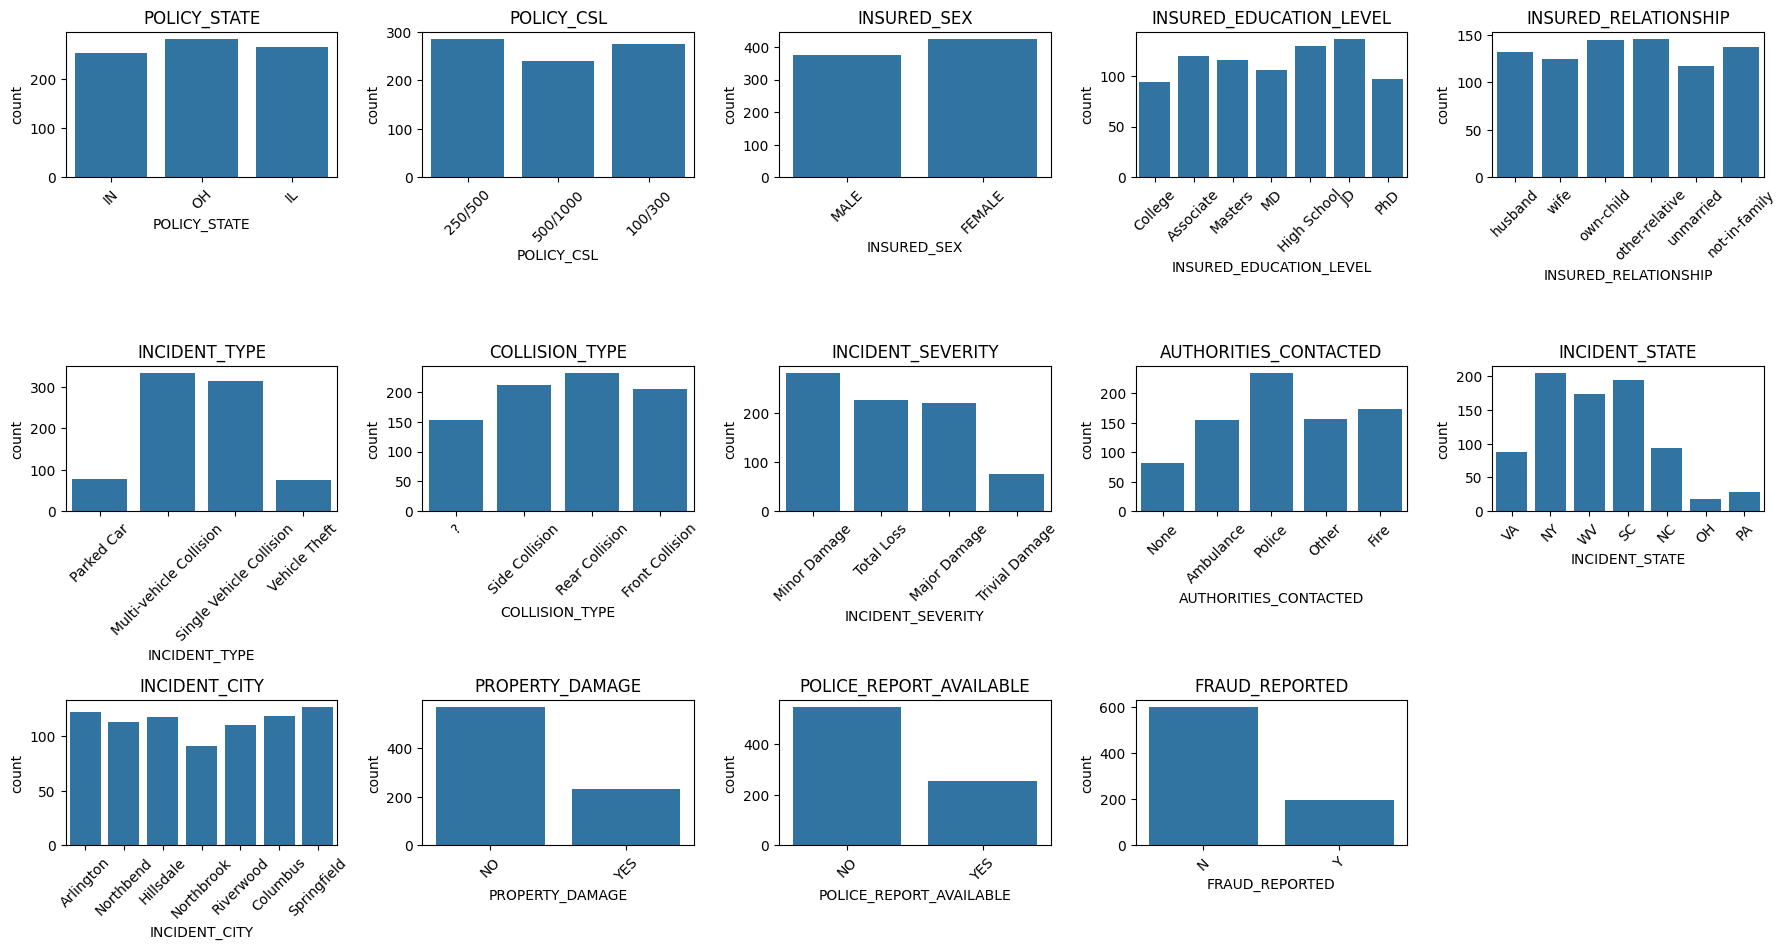

In [42]:
cat_train.drop(["POLICY_NUMBER", "INCIDENT_LOCATION", "INSURED_ZIP", "POLICY_BIND_DATE", "INCIDENT_DATE", "AUTO_MODEL", "INSURED_HOBBIES", "INSURED_OCCUPATION", "AUTO_MAKE"], axis=1, inplace=True)

fig, axes = plt.subplots(4, 5, figsize=(18, 12))
axes = axes.flatten()

# Set a limit on the number of categories to display
max_categories = 10

for i, col in enumerate(cat_train.columns):
    if cat_train[col].nunique() > max_categories:
        # Get the top categories and group the rest into 'Other'
        top_categories = cat_train[col].value_counts().nlargest(max_categories).index
        cat_train[col] = cat_train[col].apply(lambda x: x if x in top_categories else 'Other')
    sns.countplot(x=cat_train[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('cat_features_distribution.png')
plt.show()

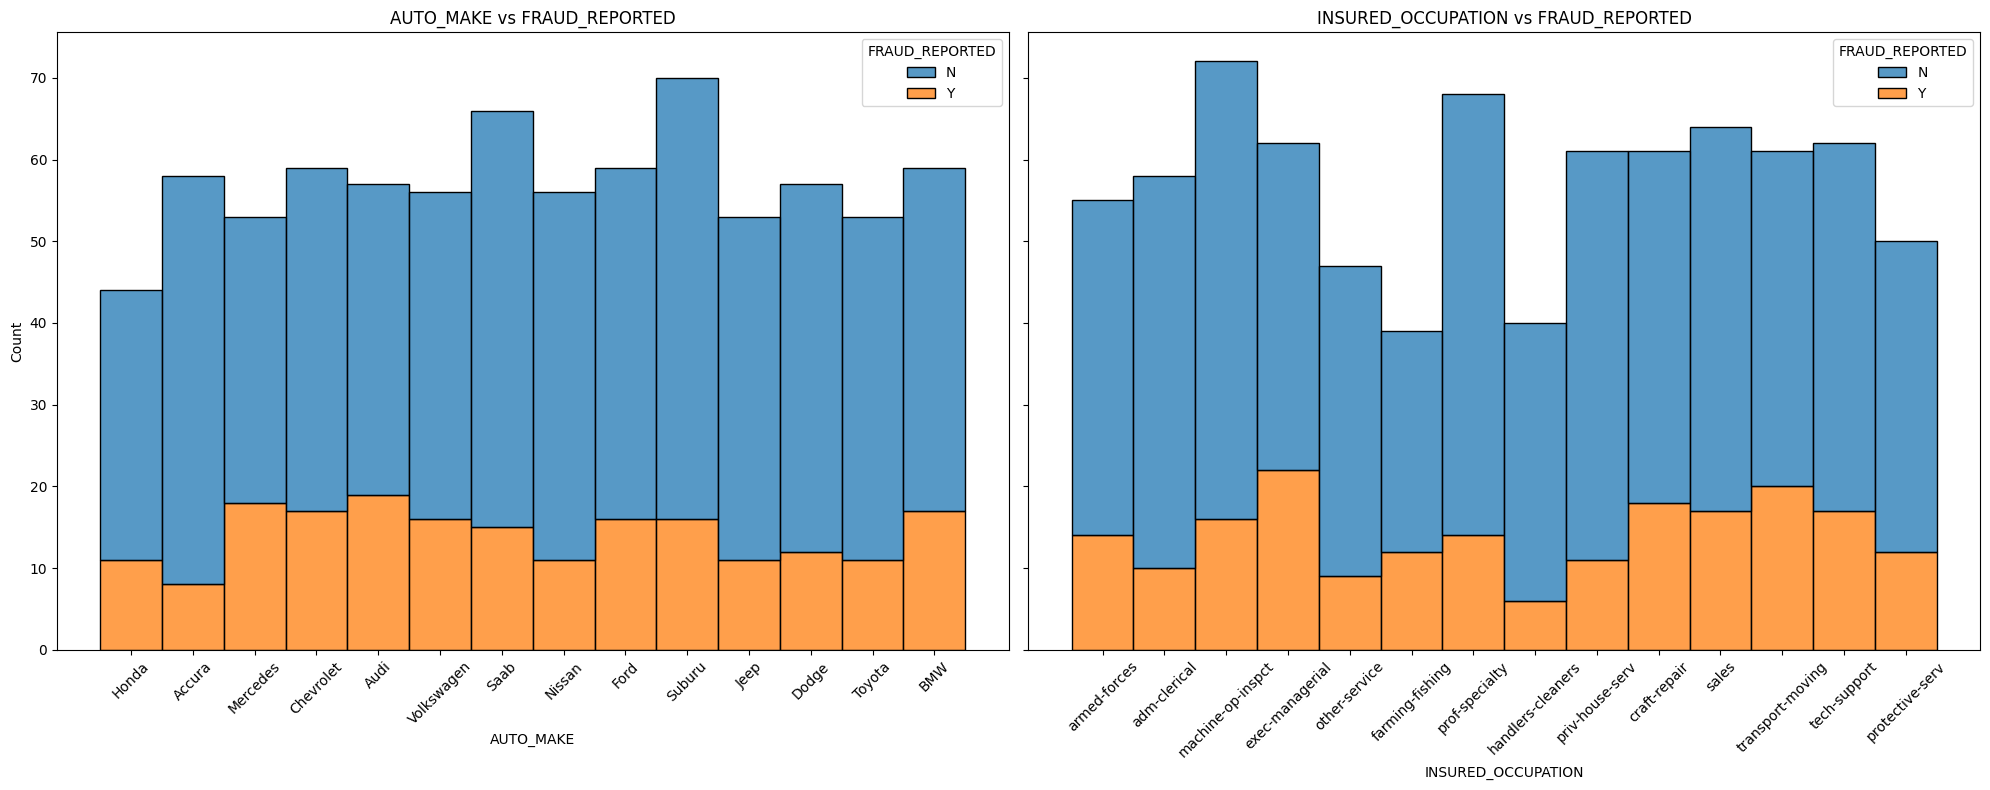

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.histplot(data=train_raw, x="AUTO_MAKE", hue="FRAUD_REPORTED", multiple="stack", ax=axes[0])
axes[0].set_title('AUTO_MAKE vs FRAUD_REPORTED')
axes[0].tick_params(axis='x', rotation=45)

sns.histplot(data=train_raw, x="INSURED_OCCUPATION", hue="FRAUD_REPORTED", multiple="stack", ax=axes[1])
axes[1].set_title('INSURED_OCCUPATION vs FRAUD_REPORTED')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<Axes: xlabel='INSURED_HOBBIES', ylabel='Count'>

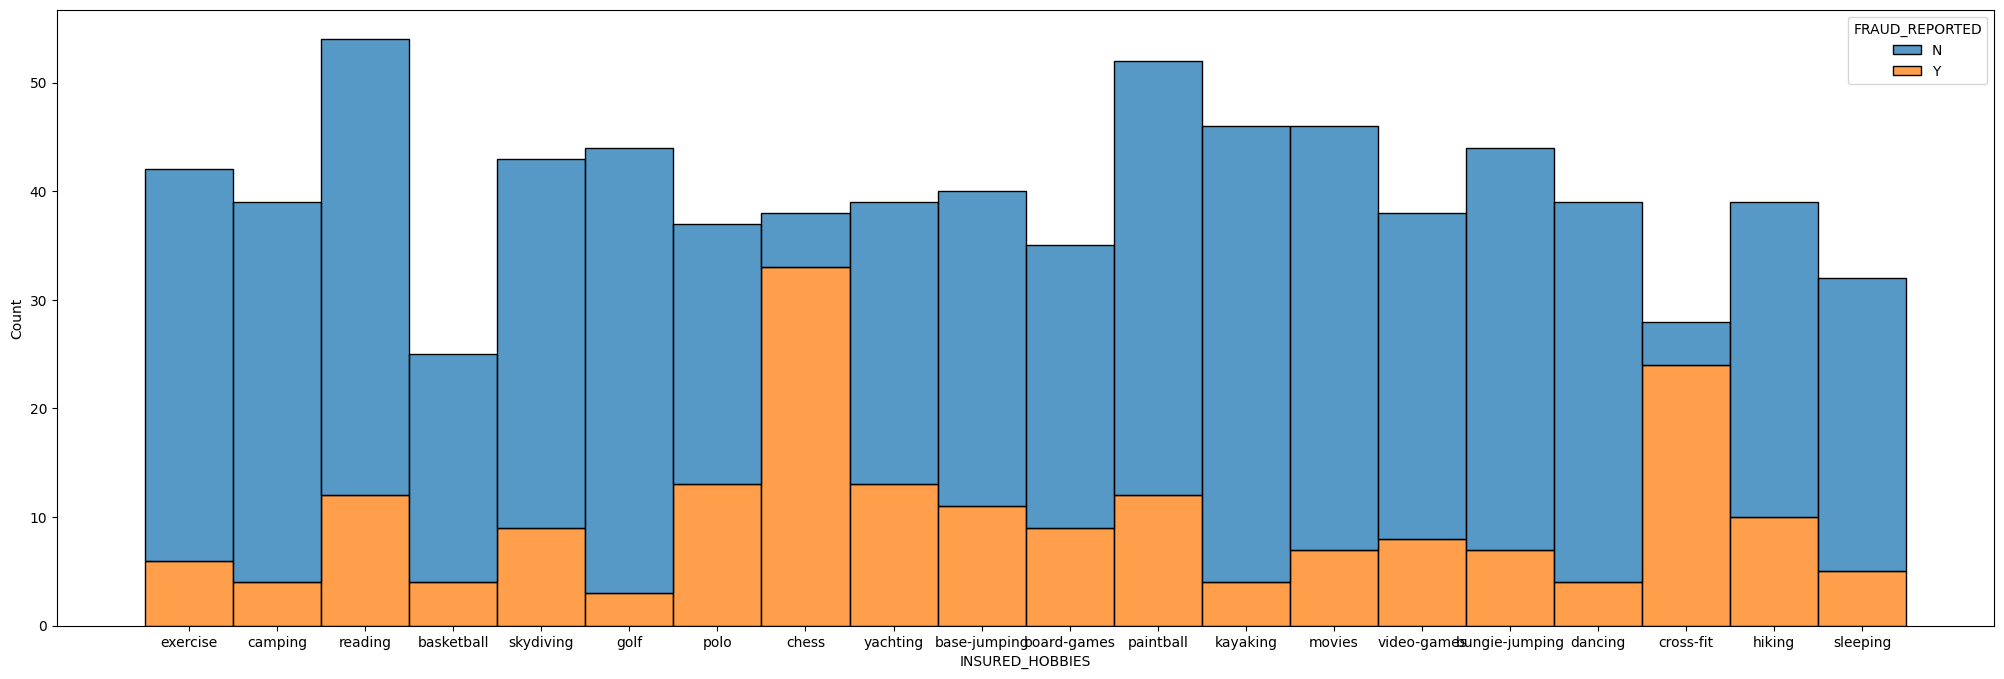

In [89]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.histplot(data=train_raw, x="INSURED_HOBBIES", hue="FRAUD_REPORTED", multiple="stack")    # Chess and cross-fit definitely stand out!

+--------------+----------------+
| POLICY_STATE | FRAUD_REPORTED |
+--------------+----------------+
|      IL      |      0.24      |
|      IN      |      0.25      |
|      OH      |      0.26      |
+--------------+----------------+


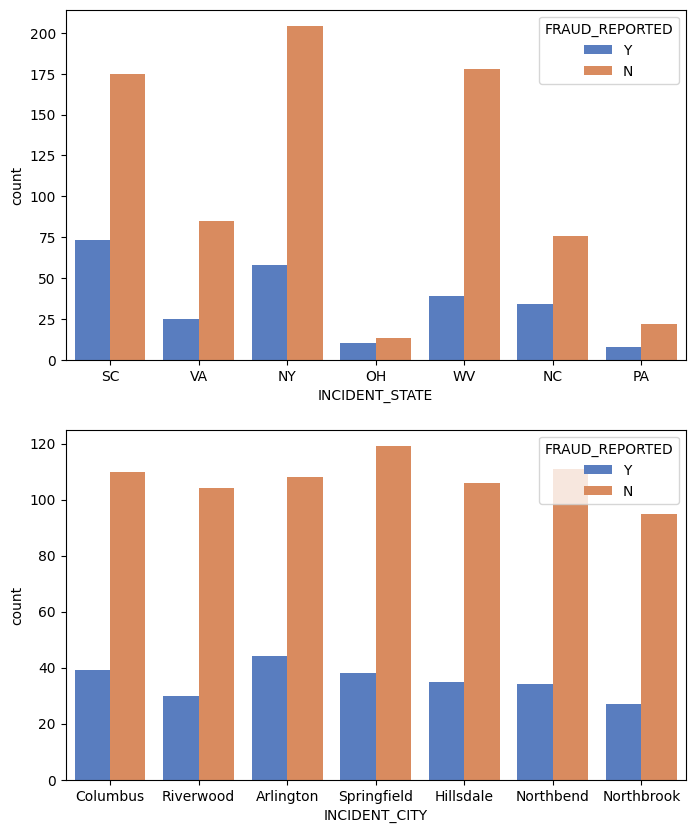

In [235]:
# Checking the geographical distribution of fraudulent cases 

fraud_prop_state = train_raw.groupby("POLICY_STATE")["FRAUD_REPORTED"].apply(lambda x: (x=='Y').mean()).reset_index()
fraud_prop_state.columns = ["POLICY_STATE", "FRAUD_REPORTED"]
fraud_prop_state["FRAUD_REPORTED"] = fraud_prop_state["FRAUD_REPORTED"].round(2)
print(tabulate(fraud_prop_state, headers='keys', tablefmt='pretty', showindex=False))
                            

fig, axes = plt.subplots(2, 1, figsize=(8, 10))
sns.countplot(data=df, x="INCIDENT_STATE", hue="FRAUD_REPORTED", ax=axes[0], palette="muted")
sns.countplot(data=df, x="INCIDENT_CITY", hue="FRAUD_REPORTED", ax=axes[1], palette="muted")
plt.show()

## 5. Prepare data for modeling
- Transform target variable to numerical 
- Divide into train and test (same random state and method as before)
- Preprocessing pipeline

In [188]:
X = df.drop(["FRAUD_REPORTED"], axis=1)
y = df["FRAUD_REPORTED"].map({'Y': 1, 'N': 0})   # transforming target variable to numerical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [189]:
print("Shape of train set: ", X_train.shape)
print("\nShape of test set: ", X_test.shape)

train_fraud_ratio = y_train.value_counts(normalize=True) * 100
test_fraud_ratio = y_test.value_counts(normalize=True) * 100

print("\nFraud ratio in the train set:")
print(train_fraud_ratio.values)

print("\nFraud ratio in the test set:")
print(test_fraud_ratio.values)

Shape of train set:  (800, 39)

Shape of test set:  (200, 39)

Fraud ratio in the train set:
[75.25 24.75]

Fraud ratio in the test set:
[75.5 24.5]


### 5.1 Data Preprocessing Pipeline

- Data cleaning 
- Drop columns
- Impute missing values
- Encode categorical features
- Normalize/scale features

In [190]:
# Data cleaning function
def data_cleaning(df):
    return df.replace("?", np.nan)

# Dropping columns that will not be used
def drop_columns(df):
    columns_to_drop = ["AGE", "TOTAL_CLAIM_AMOUNT", "POLICY_NUMBER", "INCIDENT_LOCATION", 
                "POLICY_BIND_DATE", "INCIDENT_DATE", "UMBRELLA_LIMIT",
                "AUTO_MODEL", "AUTO_YEAR", "_C39"]
    return df.drop(columns_to_drop, axis=1)

# Impute missing values
def imputer(df):
    df["COLLISION_TYPE"] = df["COLLISION_TYPE"].fillna(df["COLLISION_TYPE"].mode()[0])
    df["PROPERTY_DAMAGE"] = df["PROPERTY_DAMAGE"].fillna("NO")
    df["POLICE_REPORT_AVAILABLE"] = df["POLICE_REPORT_AVAILABLE"].fillna("NO")
    df["AUTHORITIES_CONTACTED"] = df["AUTHORITIES_CONTACTED"].fillna("None")
    return df

# Encode categorical variables
def one_hot_encode(df):
    return pd.get_dummies(df, drop_first=True)

# Define the pipeline steps
preprocessing_pipeline = Pipeline(steps=[
    ('cleaning', FunctionTransformer(data_cleaning, validate=False)),
    ('dropping', FunctionTransformer(drop_columns, validate=False)),
    ('imputing', FunctionTransformer(imputer, validate=False)),
    ('one_hot_encoding', FunctionTransformer(one_hot_encode, validate=False)),
    ('scaler', MinMaxScaler())
])

# Fit pipeline on training data and then transform on both training and test data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

In [191]:
# Print shapes to confirm
print("Transformed Train set shape: ", X_train_transformed.shape)
print("Transformed Test set shape: ", X_test_transformed.shape)

Transformed Train set shape:  (800, 100)
Transformed Test set shape:  (200, 100)


In [192]:
# Get feature names after preprocessing to create a new dataframe
X_train_encoded = preprocessing_pipeline.named_steps['one_hot_encoding'].transform(imputer(drop_columns(data_cleaning(X_train))))
encoded_columns = pd.get_dummies(imputer(drop_columns(data_cleaning(X_train))), drop_first=True).columns
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=encoded_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=encoded_columns)

X_train_transformed_df.head()

,MONTHS_AS_CUSTOMER,POLICY_DEDUCTABLE,POLICY_ANNUAL_PREMIUM,INSURED_ZIP,CAPITAL-GAINS,CAPITAL-LOSS,INCIDENT_HOUR_OF_THE_DAY,NUMBER_OF_VEHICLES_INVOLVED,BODILY_INJURIES,WITNESSES,...,AUTO_MAKE_Dodge,AUTO_MAKE_Ford,AUTO_MAKE_Honda,AUTO_MAKE_Jeep,AUTO_MAKE_Mercedes,AUTO_MAKE_Nissan,AUTO_MAKE_Saab,AUTO_MAKE_Suburu,AUTO_MAKE_Toyota,AUTO_MAKE_Volkswagen
0,0.920668,0.000000,0.518479,0.101211,0.238806,0.545455,0.173913,0.000000,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.574113,1.000000,0.628424,0.920328,0.392040,0.424842,0.347826,0.666667,0.5,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.878914,0.000000,0.930779,0.213363,0.492537,0.270027,0.304348,0.000000,1.0,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.008351,0.000000,0.526309,0.974662,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.536534,0.333333,0.525039,0.020314,0.591045,0.710171,0.913043,0.000000,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.2 Addressing class imbalance
Applying the SMOTE method to visualise the difference in class distribution before and after SMOTE.

C:\Users\tovat\AppData\Local\Temp\ipykernel_13364\1549806988.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=ax[0], palette="muted")
C:\Users\tovat\AppData\Local\Temp\ipykernel_13364\1549806988.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_SMOTE, ax=ax[1], palette="muted")


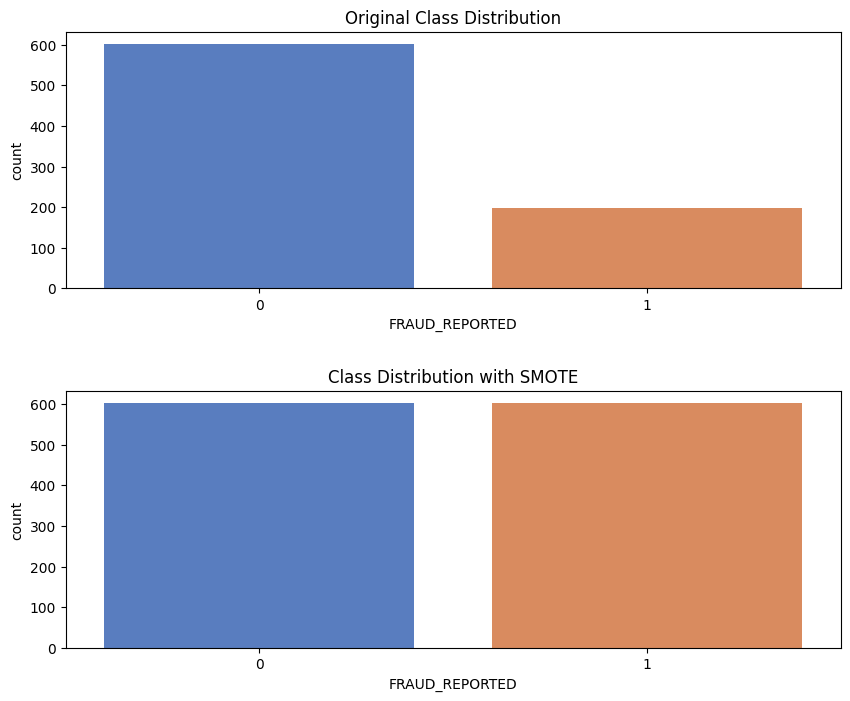

In [237]:
method = SMOTE(random_state=42)

X_SMOTE, y_SMOTE = method.fit_resample(X_train_transformed, y_train)

fig, ax = plt.subplots(2, 1, figsize=(10,8))
sns.countplot(x=y_train, ax=ax[0], palette="muted")
sns.countplot(x=y_SMOTE, ax=ax[1], palette="muted")

ax[0].set_title('Original Class Distribution')
ax[1].set_title('Class Distribution with SMOTE')
plt.subplots_adjust(hspace=0.4)

In [238]:
print(f"Original training set shape: {Counter(y_train)}")
print(f"Resampled training set shape: {Counter(y_SMOTE)}")

Original training set shape: Counter({0: 602, 1: 198})
Resampled training set shape: Counter({0: 602, 1: 602})


## 6. Feature Selection

Both MI-scores and ANOVA table were calculated and features with MI-scores below 0.01 were removed (X_train_transformed_reduced). The reduced dataset was assessed during cross-validation but showed no significant improvement for the algorithms and as such, the decision was made to retain all features. 

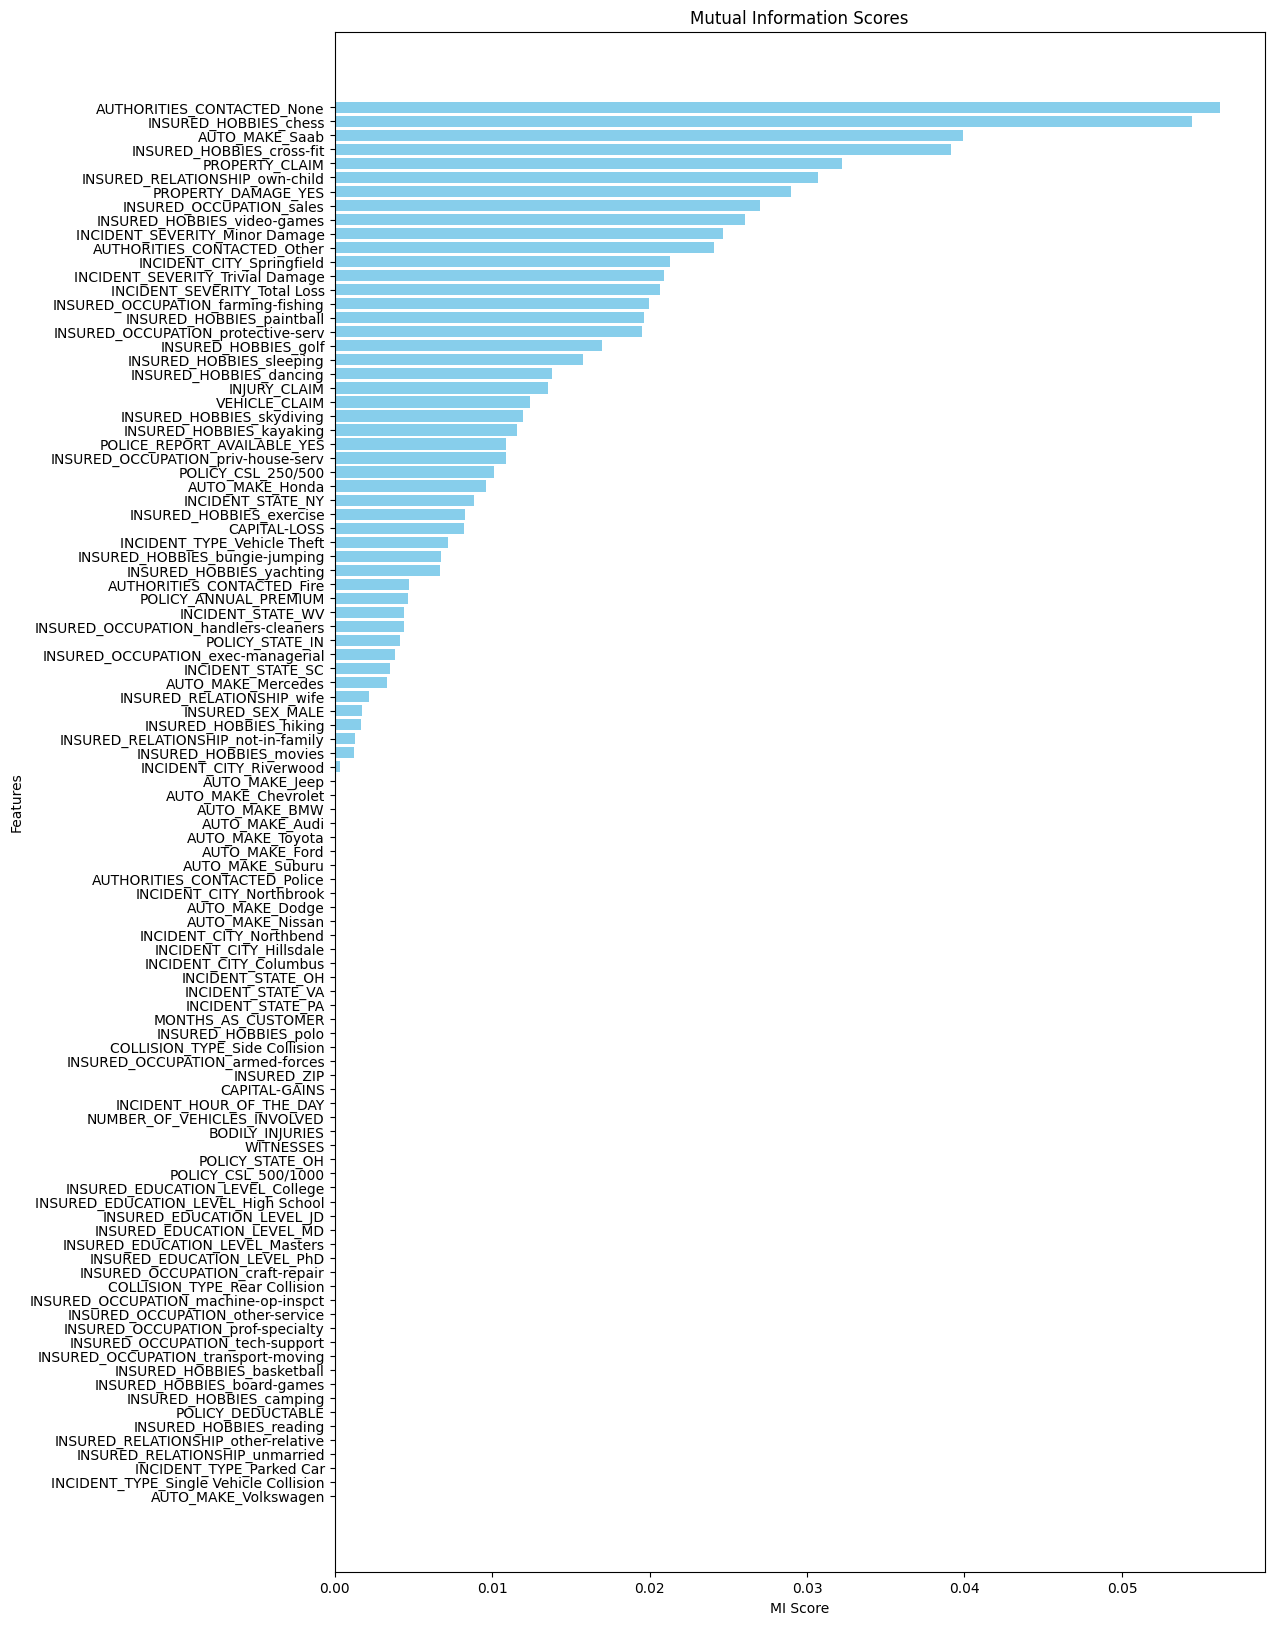

In [228]:
# Calculate MI Scores
mi_scores = mutual_info_classif(X_train_transformed, y_train, discrete_features='auto', random_state=42)

# Create a DataFrame for visualization
mi_scores_df = pd.DataFrame({'Feature': X_train_transformed_df.columns, 'MI Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)

threshold = 0.01

# Filter features with MI Score above the threshold
significant_features = mi_scores_df[mi_scores_df['MI Score'] > threshold]['Feature'].tolist()

# Remove non-significant features from X_train_transformed
X_train_transformed_reduced = X_train_transformed_df[significant_features]

# Visualize MI Scores
plt.figure(figsize=(12, 20))
plt.barh(mi_scores_df['Feature'], mi_scores_df['MI Score'], color='skyblue')
plt.xlabel('MI Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores')
plt.gca().invert_yaxis()
plt.show()

In [229]:
X_test_transformed_reduced = X_test_transformed_df[significant_features] 

In [230]:
# Perform ANOVA for feature selection and select top k features with highest F-values
k = 20  
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)

# Get the selected feature names
selected_features = X_train_transformed_df.columns[selector.get_support()]

print("Selected features based on ANOVA F-value:")
print(selected_features)

Selected features based on ANOVA F-value:
Index(['INJURY_CLAIM', 'PROPERTY_CLAIM', 'VEHICLE_CLAIM',
       'INSURED_OCCUPATION_exec-managerial', 'INSURED_HOBBIES_camping',
       'INSURED_HOBBIES_chess', 'INSURED_HOBBIES_cross-fit',
       'INSURED_HOBBIES_dancing', 'INSURED_HOBBIES_golf',
       'INSURED_HOBBIES_kayaking', 'INCIDENT_TYPE_Parked Car',
       'INCIDENT_TYPE_Single Vehicle Collision', 'INCIDENT_TYPE_Vehicle Theft',
       'INCIDENT_SEVERITY_Minor Damage', 'INCIDENT_SEVERITY_Total Loss',
       'INCIDENT_SEVERITY_Trivial Damage', 'AUTHORITIES_CONTACTED_None',
       'INCIDENT_STATE_OH', 'INCIDENT_STATE_SC', 'INCIDENT_STATE_WV'],
      dtype='object')


## 7. Modeling pipeline

In [197]:
pipeline_original = Pipeline([
    ('classifier', None)
])

pipeline_SMOTE = ImbPipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', None)
])

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': LGBMClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [198]:
# Define a custom scorer for F-beta (beta=5) score
fbeta_scorer = make_scorer(fbeta_score, beta=5)

# Define a metrics calculator that will be used for all evaluations 
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=5)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'precision': precision,
        'recall': recall,
        'fbeta': fbeta,
        'false_positives': fp,
        'false_negatives': fn
    }

In [199]:
# Evaluation dictionary to store results
evaluation_results = {}

# Perform cross-validation for each pipeline and classifier
for pipeline_name, pipeline in [('Original Data', pipeline_original), ('SMOTE', pipeline_SMOTE)]:
    print(f'Pipeline: {pipeline_name}')
    
    # Iterate over classifiers
    for clf_name, clf in classifiers.items():
        print(f'Classifier: {clf_name}')
        
        # Set classifier in the pipeline
        pipeline.steps[-1] = ('classifier', clf)
        
        # Perform cross-validation predictions 
        y_pred_cv = cross_val_predict(pipeline, X_train_transformed, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1)
        
        # Calculate evaluation metrics
        metrics = calculate_metrics(y_train, y_pred_cv)
        roc_auc = roc_auc_score(y_train, y_pred_cv)
        
        # Store evaluation results
        evaluation_results[(pipeline_name, clf_name)] = {
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'F-beta (beta=5)': metrics['fbeta'],
            'false_positives': metrics['false_positives'],
            'false_negatives': metrics['false_negatives'],
            'ROC-AUC': roc_auc
        }

# Print final evaluation results
print('\nFinal Evaluation Results:')
for key, result in evaluation_results.items():
    print(f'{key}:')
    print(f'Precision: {result["precision"]:.4f}')
    print(f'Recall: {result["recall"]:.4f}')
    print(f'F-beta Score (beta=5): {result["F-beta (beta=5)"]:.4f}')
    print(f'False Positives: {result["false_positives"]}')
    print(f'False Negatives: {result["false_negatives"]}')
    print(f'ROC-AUC Score: {result["ROC-AUC"]:.4f}')
    print()

Pipeline: Original Data
Classifier: LogisticRegression
Classifier: RandomForestClassifier
Classifier: GradientBoostingClassifier
Classifier: AdaBoostClassifier
Classifier: ExtraTreesClassifier
Classifier: XGBClassifier
Classifier: LGBMClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: DecisionTreeClassifier
Pipeline: SMOTE
Classifier: LogisticRegression
Classifier: RandomForestClassifier
Classifier: GradientBoostingClassifier
Classifier: AdaBoostClassifier
Classifier: ExtraTreesClassifier
Classifier: XGBClassifier
Classifier: LGBMClassifier
Classifier: KNeighborsClassifier
Classifier: SVC
Classifier: DecisionTreeClassifier

Final Evaluation Results:
('Original Data', 'LogisticRegression'):
Precision: 0.7135
Recall: 0.6162
F-beta Score (beta=5): 0.6194
False Positives: 49
False Negatives: 76
ROC-AUC Score: 0.7674

('Original Data', 'RandomForestClassifier'):
Precision: 0.7895
Recall: 0.2273
F-beta Score (beta=5): 0.2337
False Positives: 12
False Negatives: 153
ROC-A

### 7.1 Baseline models evaluation
Evaluating on ROC-AUC and F-beta scores. In the cell below the ROC-AUC scores are demonstrated, and the model's improvement with SMOTE transformed data. 

                   Classifier  Original   SMOTE  Difference
8                         SVC    0.8105  0.8418      0.0313
0          LogisticRegression    0.7953  0.8613      0.0660
2  GradientBoostingClassifier    0.7709  0.8342      0.0633
4        ExtraTreesClassifier    0.7608  0.7693      0.0085
5               XGBClassifier    0.7574  0.7955      0.0381
1      RandomForestClassifier    0.7557  0.8021      0.0464
9      DecisionTreeClassifier    0.7475  0.7484      0.0009
6              LGBMClassifier    0.7373  0.8039      0.0666
3          AdaBoostClassifier    0.7228  0.8131      0.0903
7        KNeighborsClassifier    0.6757  0.7466      0.0709


C:\Users\tovat\AppData\Local\Temp\ipykernel_13364\714689556.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=cv_scores_sorted, x='SMOTE', y='Classifier', color='skyblue', label='SMOTE', ci=None)
C:\Users\tovat\AppData\Local\Temp\ipykernel_13364\714689556.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=cv_scores_sorted, x='Original', y='Classifier', color='lightgreen', label='Original', ci=None)


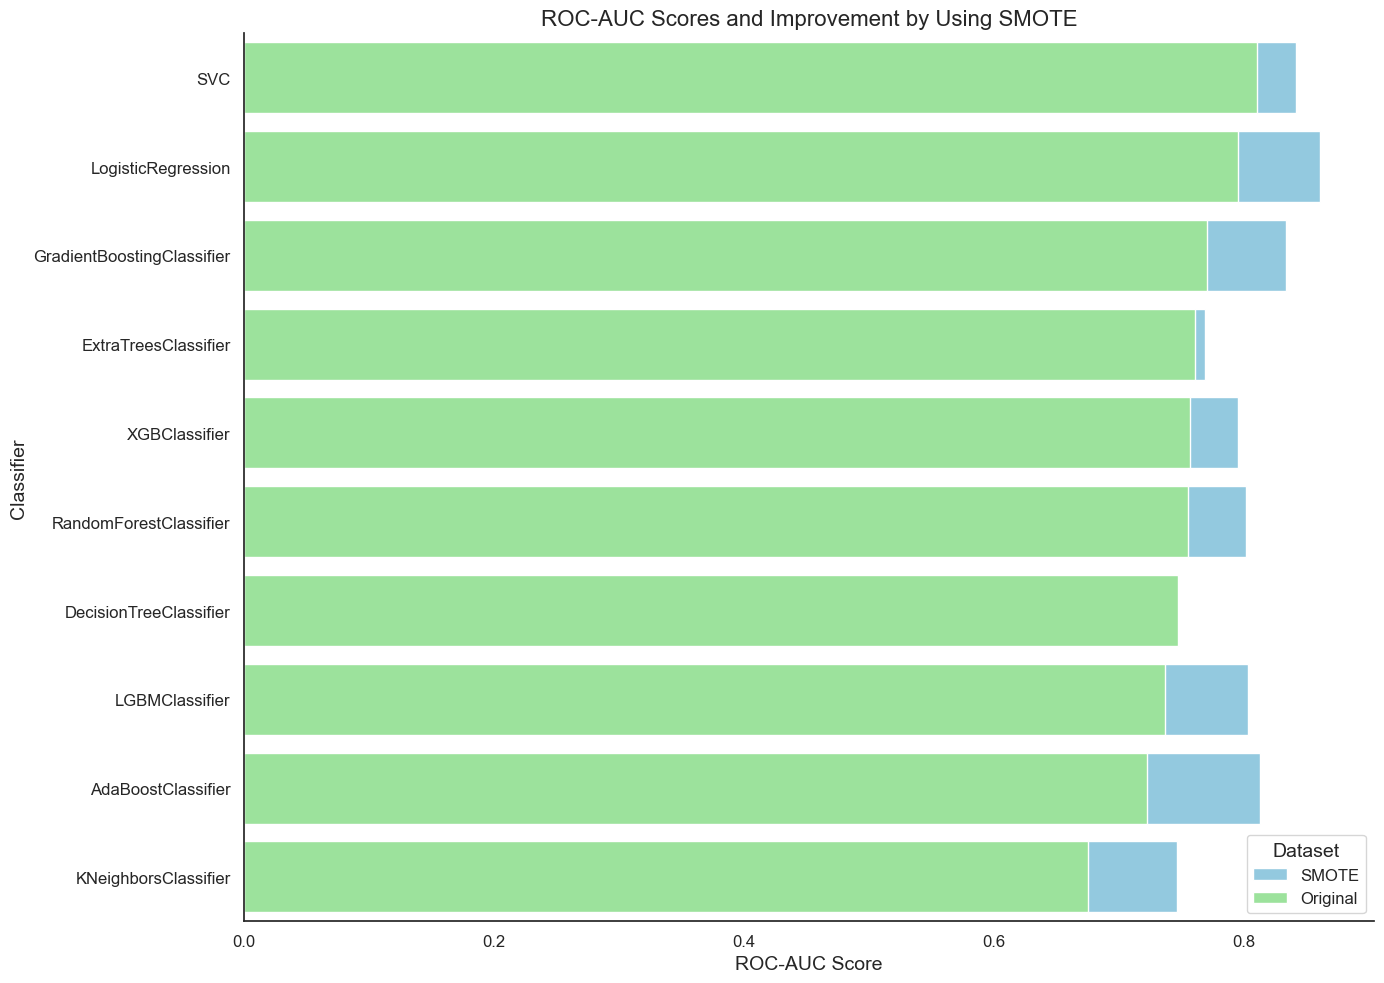

In [250]:
# Define the classifiers
classifiers = [
    'LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 
    'AdaBoostClassifier', 'ExtraTreesClassifier', 'XGBClassifier', 
    'LGBMClassifier', 'KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier'
]

# ROC-AUC scores for each classifier in Original Data pipeline
roc_auc_original = [
    0.7953, 0.7557, 0.7709, 0.7228, 0.7608, 0.7574, 0.7373, 0.6757, 0.8105, 0.7475
]

# ROC-AUC scores for each classifier in SMOTE pipeline
roc_auc_smote = [
    0.8613, 0.8021, 0.8342, 0.8131, 0.7693, 0.7955, 0.8039, 0.7466, 0.8418, 0.7484
]

# Difference / Improvement in using original vs SMOTE data
diff = [(smote-original) for smote, original in zip(roc_auc_smote, roc_auc_original)]

cv_scores = pd.DataFrame({
    'Classifier': classifiers, 
    'Original': roc_auc_original,
    'SMOTE': roc_auc_smote,
    'Difference': diff
})

cv_scores_sorted = cv_scores.sort_values(by='Original', ascending=False)
print(cv_scores_sorted)   

# Plotting with seaborn
plt.figure(figsize=(14, 10))
sns.set(style="white")

# Plot the ROC-AUC scores with SMOTE and Original data
sns.barplot(data=cv_scores_sorted, x='SMOTE', y='Classifier', color='skyblue', label='SMOTE', ci=None)
sns.barplot(data=cv_scores_sorted, x='Original', y='Classifier', color='lightgreen', label='Original', ci=None)

# Customize plot labels and style
plt.xlabel('ROC-AUC Score', fontsize=14)
plt.ylabel('Classifier', fontsize=14)
plt.title('ROC-AUC Scores and Improvement by Using SMOTE', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Dataset', fontsize=12, title_fontsize=14)

sns.despine()
plt.tight_layout()
plt.show()


### 7.3 Model Optimization
Hyperparameter tuning for the three best performing baseline models on the SMOTE transformed dataset.

In [200]:
# Defining classifiers with their parameter grids for hyperparameter tuning
classifiers = {
    'SVC': {
        'classifier': SVC(probability=True),
        'param_grid': {
            'C': [0.1, 1, 10, 100],
            'gamma': [1, 0.1, 0.01, 0.001],
            'kernel': ['linear', 'rbf', 'poly']
        }
    },
    'LogisticRegression': {
        'classifier': LogisticRegression(),
        'param_grid': {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        }
    },
    'GradientBoostingClassifier': {
        'classifier': GradientBoostingClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 7]
        }
    }
}

In [233]:
# Evaluation dictionary to store results
evaluation_results = {}

# Perform cross-validation for each classifier
for clf_name, clf_data in classifiers.items():
    print(f'Classifier: {clf_name}')
    
    # Set classifier in the SMOTE pipeline
    pipeline_SMOTE.steps[-1] = ('classifier', clf_data['classifier'])
    
    # Perform GridSearchCV for hyperparameter tuning with cross-validation
    grid_search = GridSearchCV(pipeline_SMOTE, clf_data['param_grid'], cv=5, scoring=fbeta_scorer, verbose=2, n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)  
    
    # Best parameters and best estimator
    print(f"Best parameters: {grid_search.best_params_}")
    best_clf = grid_search.best_estimator_
    
    # Perform cross-validation predictions with best estimator
    y_pred_cv = cross_val_predict(best_clf, X_train_transformed, y_train, cv=5, n_jobs=-1)
    
    # Calculate evaluation metrics
    metrics = calculate_metrics(y_train, y_pred_cv)
    
    # Store evaluation results
    evaluation_results[clf_name] = {
        'best_params': best_clf.named_steps['classifier'].get_params(),
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'F-beta (beta=5)': metrics['F-beta (beta=5)'],
        'false_positives': metrics['false_positives'],
        'false_negatives': metrics['false_negatives'],
        'ROC-AUC': metrics['ROC-AUC']
    }
    
# Print final evaluation results
print('\nFinal Evaluation Results:')
for clf_name, result in evaluation_results.items():
    print(f'{clf_name}:')
    print(f'Best parameters: {result["best_params"]}')
    print(f'Precision: {result["precision"]:.4f}')
    print(f'Recall: {result["recall"]:.4f}')
    print(f'F-beta Score (beta=5): {result["F-beta (beta=5)"]:.4f}')
    print(f'False Positives: {result["false_positives"]}')
    print(f'False Negatives: {result["false_negatives"]}')
    print(f'ROC-AUC Score: {result["ROC-AUC"]:.4f}')
    print()


Classifier: SVC
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 1, 'classifier__kernel': 'linear'}
Classifier: LogisticRegression
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\tovat\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\tovat\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tovat\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\tovat\anaconda3\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt,

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Classifier: GradientBoostingClassifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}

Final Evaluation Results:
SVC:
Best parameters: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Precision: 0.6531
Recall: 0.8939
F-beta Score (beta=5): 0.8814
False Positives: 94
False Negatives: 21
ROC-AUC Score: 0.8689

LogisticRegression:
Best parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', '

### 7.4  Final evaluation on test data
The best performing model (Logistic Regression) will be assessed on test data

In [240]:
# Accessing the best params from Logreg
best_params_logreg = evaluation_results['LogisticRegression']['best_params']

# Define new pipeline
pipeline_logreg = ImbPipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(**best_params_logreg))  # Using the best parameters
])

# Fit pipeline on X_train_transformed and y_train
pipeline_logreg.fit(X_train_transformed, y_train)

# Predict on the test data with SMOTE-applied Logistic Regression model
y_pred_test_logreg = pipeline_logreg.predict(X_test_transformed)

# Calculate evaluation metrics on test data
metrics_test_logreg = calculate_metrics(y_test, y_pred_test_logreg)

# Print evaluation metrics on test data
print('\nEvaluation Metrics on Test Data:')
print(f'Precision: {metrics_test_logreg["precision"]:.4f}')
print(f'Recall: {metrics_test_logreg["recall"]:.4f}')
print(f'F-beta Score (beta=5): {metrics_test_logreg["F-beta (beta=5)"]:.4f}')
print(f'ROC-AUC Score: {metrics_test_logreg["ROC-AUC"]:.4f}')
print(f'False Positives: {metrics_test_logreg["false_positives"]}')
print(f'False Negatives: {metrics_test_logreg["false_negatives"]}')



Evaluation Metrics on Test Data:
Precision: 0.6364
Recall: 0.8571
F-beta Score (beta=5): 0.8459
ROC-AUC Score: 0.8491
False Positives: 24
False Negatives: 7


In [241]:
# Checking performance on training data to assess whether the model is overfitting

y_pred_train_logreg = pipeline_logreg.predict(X_train_transformed)
metrics_train_logreg = calculate_metrics(y_train, y_pred_train_logreg)

# Print evaluation metrics on training data
print('Evaluation Metrics on Training Data:')
print(f'Precision: {metrics_train_logreg["precision"]:.4f}')
print(f'Recall: {metrics_train_logreg["recall"]:.4f}')
print(f'F-beta Score (beta=5): {metrics_train_logreg["F-beta (beta=5)"]:.4f}')
print(f'ROC-AUC Score: {metrics_train_logreg["ROC-AUC"]:.4f}')
print(f'False Positives: {metrics_train_logreg["false_positives"]}')
print(f'False Negatives: {metrics_train_logreg["false_negatives"]}')

Evaluation Metrics on Training Data:
Precision: 0.6531
Recall: 0.8939
F-beta Score (beta=5): 0.8814
ROC-AUC Score: 0.8689
False Positives: 94
False Negatives: 21


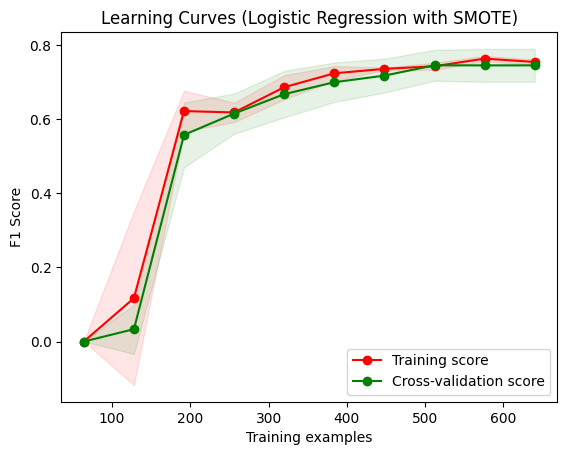

In [242]:
# Function to plot learning curves
def plot_learning_curves(estimator, title, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='f1', n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curves 
plot_learning_curves(pipeline_logreg, "Learning Curves (Logistic Regression with SMOTE)",
                     X_train_transformed, y_train)

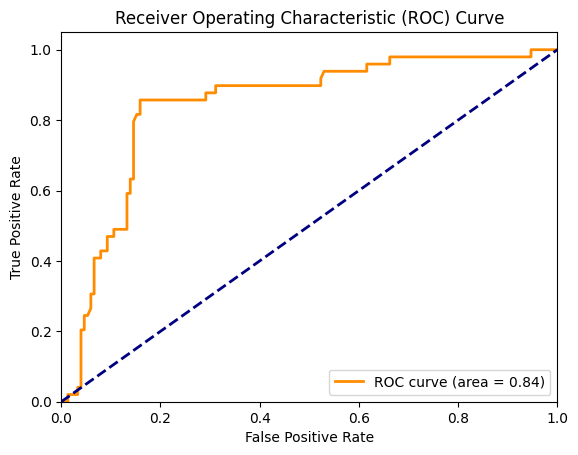

In [244]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, pipeline_logreg.predict_proba(X_test_transformed)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

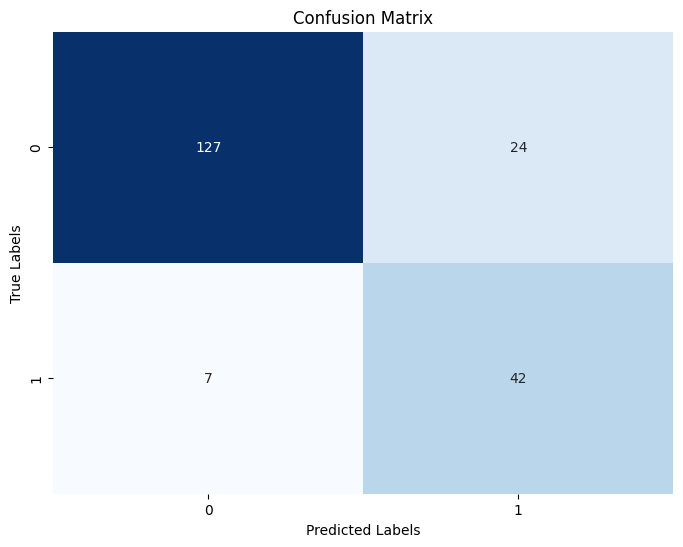

In [204]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test_logreg)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [245]:
#### Extracting feature importance

logreg_model = pipeline_logreg.named_steps['classifier']
feature_importance = logreg_model.coef_[0]

# Pair feature names with coefficients and sort based on absolute value
feature_importance_list = list(zip(X_train_transformed_df.columns, feature_importance))
feature_importance_list.sort(key=lambda x: abs(x[1]), reverse=True)

# Print feature importance
print("Feature Importance:")
for feature, coef in feature_importance_list:
    print(f"{feature}: {coef:.4f}")

Feature Importance:
INSURED_HOBBIES_chess: 3.0887
INSURED_HOBBIES_cross-fit: 2.7745
INCIDENT_SEVERITY_Minor Damage: -2.5400
INCIDENT_SEVERITY_Total Loss: -2.4737
INCIDENT_SEVERITY_Trivial Damage: -2.0892
WITNESSES: 0.3644
INCIDENT_STATE_SC: 0.3378
INCIDENT_TYPE_Single Vehicle Collision: 0.2168
BODILY_INJURIES: 0.1289
POLICY_CSL_250/500: 0.0754
COLLISION_TYPE_Rear Collision: 0.0580
PROPERTY_DAMAGE_YES: 0.0055
MONTHS_AS_CUSTOMER: 0.0000
POLICY_DEDUCTABLE: 0.0000
POLICY_ANNUAL_PREMIUM: 0.0000
INSURED_ZIP: 0.0000
CAPITAL-GAINS: 0.0000
CAPITAL-LOSS: 0.0000
INCIDENT_HOUR_OF_THE_DAY: 0.0000
NUMBER_OF_VEHICLES_INVOLVED: 0.0000
INJURY_CLAIM: 0.0000
PROPERTY_CLAIM: 0.0000
VEHICLE_CLAIM: 0.0000
POLICY_STATE_IN: 0.0000
POLICY_STATE_OH: 0.0000
POLICY_CSL_500/1000: 0.0000
INSURED_SEX_MALE: 0.0000
INSURED_EDUCATION_LEVEL_College: 0.0000
INSURED_EDUCATION_LEVEL_High School: 0.0000
INSURED_EDUCATION_LEVEL_JD: 0.0000
INSURED_EDUCATION_LEVEL_MD: 0.0000
INSURED_EDUCATION_LEVEL_Masters: 0.0000
INSURED_EDUC